<a href="https://colab.research.google.com/github/DatumLearning/Simple_autoencoder_pytorch/blob/main/simple_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.ToTensor()

In [ ]:
train_dataset = torchvision.datasets.MNIST(root = "./data" , train = True , download = True ,  transform = transform)
valid_dataset = torchvision.datasets.MNIST(root = "./data" , train = False , download = True ,  transform = transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_dl = torch.utils.data.DataLoader(train_dataset , batch_size = 100)

In [ ]:
class Encoder(nn.Module):
  def __init__(self , input_size = 28*28 , hidden_size1 = 128 , hidden_size2 = 16 , z_dim = 2):
    super().__init__()
    self.fc1 = nn.Linear(input_size , hidden_size1)
    self.fc2 = nn.Linear(hidden_size1 , hidden_size2)
    self.fc3 = nn.Linear(hidden_size2 , z_dim)
    self.relu = nn.ReLU()
  def forward(self , x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
class Decoder(nn.Module):
  def __init__(self , output_size = 28*28 , hidden_size1 = 128 , hidden_size2 = 16 , z_dim = 2):
    super().__init__()
    self.fc1 = nn.Linear(z_dim , hidden_size2)
    self.fc2 = nn.Linear(hidden_size2 , hidden_size1)
    self.fc3 = nn.Linear(hidden_size1 , output_size)
    self.relu = nn.ReLU()
  def forward(self , x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
enc = Encoder().to(device)
dec = Decoder().to(device)

In [ ]:
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

In [ ]:
train_loss = []

In [ ]:
num_epochs = 200

In [ ]:
for epoch in range(num_epochs):
  train_epoch_loss = 0
  for (imgs , _) in train_dl:
    imgs = imgs.to(device)
    #100 , 1 , 28 , 28 ---> (100 , 28*28)
    imgs = imgs.flatten(1)
    latents = enc(imgs)
    output = dec(latents)
    loss = loss_fn(output , imgs)
    train_epoch_loss += loss.cpu().detach().numpy()
    optimizer_enc.zero_grad()
    optimizer_dec.zero_grad()
    loss.backward()
    optimizer_enc.step()
    optimizer_dec.step()
  train_loss.append(train_epoch_loss)

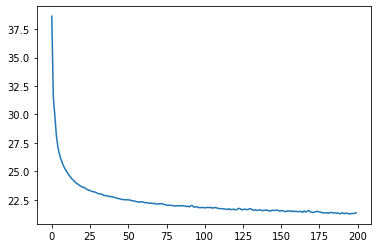

In [ ]:
plt.plot(train_loss)

In [ ]:
values = None
all_labels = []

with torch.no_grad():
  for (imgs , labels) in train_dl:
    imgs = imgs.to(device)
    imgs = imgs.flatten(1)
    all_labels.extend(list(labels.numpy()))
    latents = enc(imgs)
    if values is None:
      values = latents.cpu()
    else:
      values = torch.vstack([values , latents.cpu()])

In [ ]:
values.shape

torch.Size([60000, 2])

In [ ]:
all_labels

In [ ]:
cmap = plt.get_cmap('viridis', 10)

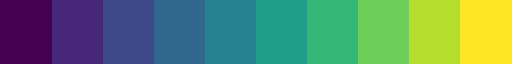

In [ ]:
cmap

In [ ]:
all_labels = np.array(all_labels)
values = values.numpy()

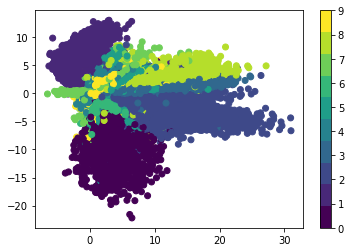

In [ ]:
pc = plt.scatter(values[: , 0] , values[: , 1] , c = all_labels , cmap = cmap)
plt.colorbar(pc)

In [ ]:
all_means = {}
for i in range(10):
  inds = np.argwhere(all_labels == i)
  num_latents = values[inds].squeeze()
  mean = num_latents.mean(axis = 0)
  all_means[i] = (mean[0] , mean[1])


In [ ]:
all_means

{0: (3.0424395, -6.938915),
 1: (-1.7455845, 4.446399),
 2: (9.183484, -2.1273322),
 3: (6.4837255, 0.33611223),
 4: (1.3717132, 0.91114056),
 5: (3.6700792, 0.8565373),
 6: (2.7475827, -1.9437323),
 7: (1.6439078, 1.5621979),
 8: (6.093855, 1.3367009),
 9: (1.3559413, 0.90110034)}

In [ ]:
torch.Tensor(all_means[0])[None , ...].shape

torch.Size([1, 2])

In [ ]:
with torch.no_grad():
  pred = dec(torch.Tensor(all_means[5])[None , ...].to(device)).cpu()
transforms.ToPILImage()(pred.reshape(1 , 28 , 28))